## Load Data

<https://archive.ics.uci.edu/ml/datasets/South+German+Credit+%28UPDATE%29>

In [3]:
import numpy as np
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, log_loss, zero_one_loss
import matplotlib.pyplot as plt
import sage


In [4]:
# Load data
df = sage.datasets.credit()

# Feature names and categorical columns (for CatBoost model)
feature_names = df.columns.tolist()
categorical_features = [
    "Credit History",
    "Purpose",
    "Credit Amount",
    "Savings Account/Bonds",
    "Employment Since",
    "Personal Status",
    "Debtors/Guarantors",
    "Property Type",
    "Other Installment Plans",
    "Housing Ownership",
    "Job",
    "Telephone",
    "Foreign Worker",
]

df[categorical_features] = df[categorical_features].astype("category")

In [5]:
len(feature_names)

21

In [6]:
# Shuffle + split into 60 % train set, 10 % val set, and 10 % test set
train, val, test = np.split(df.sample(frac=1), [int(0.8 * len(df)), int(0.9 * len(df))])

y_train, y_val, y_test = (
    train["Good Customer"],
    val["Good Customer"],
    test["Good Customer"],
)
X_train, X_val, X_test = (
    train.drop(columns="Good Customer"),
    val.drop(columns="Good Customer"),
    test.drop(columns="Good Customer"),
)

In [7]:
X_test.shape

(100, 20)

In [8]:
X_train.shape

(800, 20)

## Train model

Calculate the accuracy, cross-entropy loss, and zero-one loss of naïve prediction. The `DummyClassifier` predicts the most-frequent class passed to `fit()` when `predict()` is called and the empirical class-prior distribution when `predict_proba()` is called. See [`docs`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn-dummy-dummyclassifier).

In [9]:
naive_model = DummyClassifier(strategy="prior")
naive_model.fit(X_train, y_train)

DummyClassifier()

In [10]:
base_acc = accuracy_score(y_test, naive_model.predict(X_test))
base_zero_one_loss = zero_one_loss(y_test, naive_model.predict(X_test))
base_log_loss = log_loss(y_test, naive_model.predict_proba(X_test))

print(f"Naïve accuracy = {base_acc:.3f}")
print(f"Naïve zero-one = {base_zero_one_loss:.3f}")
print(f"Naïve cross-entropy = {base_log_loss:.3f}")

Naïve accuracy = 0.640
Naïve zero-one = 0.360
Naïve cross-entropy = 0.663


In [11]:
catboost_model = CatBoostClassifier(iterations=200, learning_rate=0.15, depth=3)

catboost_model = catboost_model.fit(
    X_train,
    y_train,
    eval_set=(X_val, y_val),
    cat_features=categorical_features,
    verbose=False,
)

In [12]:
catboost_acc = accuracy_score(y_test, catboost_model.predict(X_test))
catboost_zero_one_loss = zero_one_loss(y_test, catboost_model.predict(X_test))
catboost_log_loss = log_loss(y_test, catboost_model.predict_proba(X_test))
print(f"Catboost accuracy = {catboost_acc:.3f}")
print(f"Catboost zero-one = {catboost_zero_one_loss:.3f}")
print(f"Catboost cross-entropy = {catboost_log_loss:.3f}")

assert catboost_zero_one_loss == 1 - catboost_acc

Catboost accuracy = 0.760
Catboost zero-one = 0.240
Catboost cross-entropy = 0.522


# SIM-Shapley

In [44]:
from sim_shapley import imputers, estimator
from sim_shapley.utils import crossentropyloss

In [71]:
sim_imputer = imputers.MarginalImputer(catboost_model, X_train[:512].to_numpy(), sample_num=10)
sim_estimator = estimator.SIM_Shapley(X_train[:512].to_numpy(), sim_imputer, crossentropyloss, l2_penalty=0.01,t=0.5)
sim_value, sim_conv_list = sim_estimator(X_test.to_numpy(), y_test.to_numpy(), 200, 512, thresh=0.025, 
                                         return_convergence_process=True, random_state=233) 

  0%|          | 0/1 [00:00<?, ?it/s]

Convergence detected! Gap is 0.02453109642404026.


# Stable-SIM-Shapley

In [72]:
stable_sim_value, stable_sim_conv_list = sim_estimator(X_test.to_numpy(), y_test.to_numpy(), 200, 512, thresh=0.025, 
                                                       avoid_negative=True,return_convergence_process=True, random_state=233)

  0%|          | 0/1 [00:00<?, ?it/s]

Convergence detected! Gap is 0.024794520342220985.


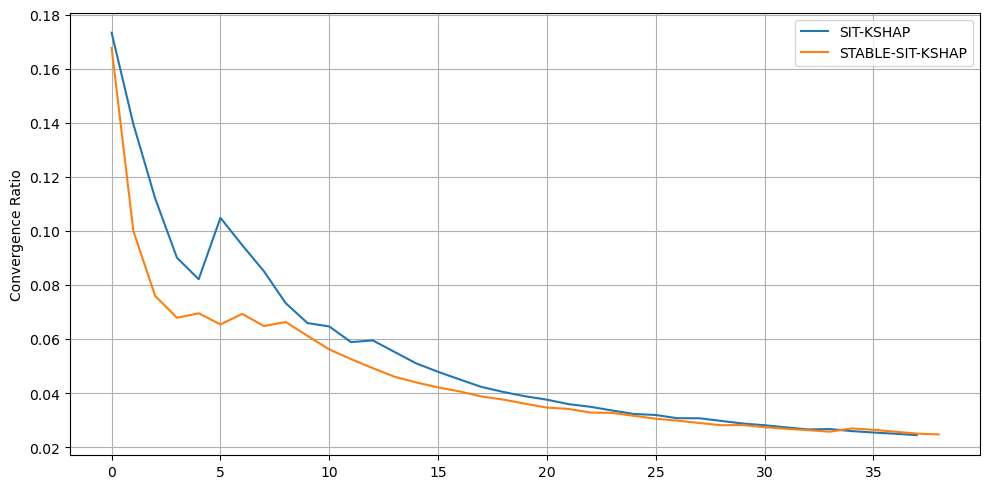

In [73]:
plt.figure(figsize=(10, 5))
plt.plot(sim_conv_list, label='SIM-Shapley')
plt.plot(stable_sim_conv_list, label='Stable-SIM-Shapley')
plt.ylabel("Convergence Ratio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Comparison

In [74]:
import scipy.stats as st
from scipy.stats import wasserstein_distance

In [75]:
# Pearson Correlation
st.pearsonr(stable_sim_value, sim_value)[0]

0.9687310670985042

In [77]:
# wasserstein_distance
wasserstein_distance(sim_value, stable_sim_value)

0.0017870192781364752